In [1]:
import cv2 
import glob 
import matplotlib.pyplot as plt 
import os 
import pandas as pd 
import re 
import tensorflow as tf 
import time 
import itertools 
import seaborn as sns 
import numpy as np  
import random 
import keras 
import datetime

from numpy import expand_dims
from keras import callbacks 
from keras.layers.normalization import BatchNormalization 
from keras import backend as k 
from keras import regularizers 
from keras.datasets import fashion_mnist 
from keras.layers import Activation, add, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, Input, Lambda, MaxPooling2D, Reshape,ZeroPadding2D,AveragePooling2D 
from keras.layers.convolutional import UpSampling2D 
from keras.losses import binary_crossentropy 
from keras.models import Model, Sequential 
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import to_categorical, plot_model 
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix 
from timeit import default_timer as timer
from keras.models import Model
from keras.layers import Input
from keras.layers import add

<h3>
    Team Member: 
    
    Nitin Kulkarni - 50337029
    
    Xiao Zhang - 50312346 
    
    Sai Charith Reddy Pasula - 50320452
</h3>

<h3>Topic:</h3> 

We intended to build a state of the art CNN like <b>ResNet/InceptionNet</b> model to classify images and compare the results with a vanilla CNN like <b>AlexNet</b>.

<h3>Link to the images:</h3>

https://drive.google.com/file/d/1MrUq-v0AUFmgqANys-a6_XrHNIQow8mq/view?usp=sharing

# Don't run this block of code if you aren't using Tensorflow-GPU.

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices------------- 1


In [3]:
# Define the size of images because the input of AlexNet should have the same size.
ROWS = 224
COLS = 224
CHANNELS = 3
CLASSES = 30

In [4]:
def read_image(file_path): # Read images and convert it into the uniform size (224x224x3)
    img_start = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img_start, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [5]:
img_start = read_image('./images/ant/1.jpg')

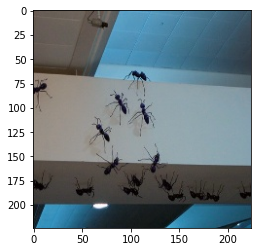

In [6]:
plt.imshow(img_start)

<h4>The size was exactly what we expected</h4>

In [7]:
print(np.shape(img_start))

(224, 224, 3)


<h4>Store the images and their folder name(it is also the label of the images) at the same time. In this way the images and the labels are in the same order. </h4>

In [8]:
filenames= os.listdir ('./images')
x_train = []
y_train = []
for folder in filenames: # Read the file name.
    for image in os.listdir(f'./images/{folder}'):# Use folder as parameter.
        img = read_image(f'./images/{folder}/{image}') # Read the files in each folder.
        x_train.append(img) # Append them (the file and label) in exact same order.
        y_train.append(folder)

<h4>Build a mapping between labels and pictures so that they can still have the same order after shuffling.</h4>

In [9]:
c = list(zip(x_train, y_train)) # build the relationship between image and label
random.shuffle(c) # shuffle
a, b = zip(*c) # get image and label back (the order of rows is changed but the label is always attached to image)

<h4>Check if the label match the picture.</h4>

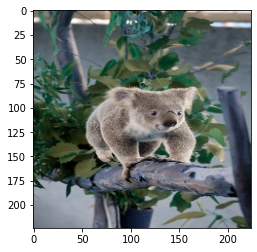

In [10]:
plt.imshow(a[1])

In [11]:
print(b[1]) # It is exactly what we expected.

koala


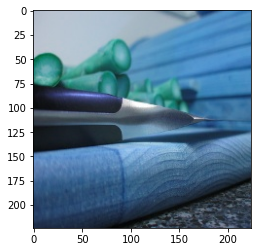

In [12]:
plt.imshow(a[111])

In [13]:
print(b[111]) # It is exactly what we expected.

asparagus


<h4>Keras cannot deal with string label so we have to encode them.</h4>

In [14]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [15]:
label_encoder.fit(["African elephant", "ant", "asparagus", "bridge", "computer keyboard","cow","dining table","Ferris wheel","flower","French bulldog","gas pump","gorilla","hula-hoop","jelly bean","jellyfish","king penguin","kiwi","koala","limousine","monarch","motorcycling","rodent","roller coaster","seashore","sea slug","sewing machine","skyscraper","snail","tiger","wasp's nest"])

LabelEncoder()

In [16]:
b_label = np.copy(b)
b_label = label_encoder.transform(b_label)

In [17]:
print(b)# These are what the original labels look like.

("wasp's nest", 'koala', 'rodent', 'French bulldog', 'bridge', 'jelly bean', 'sewing machine', 'bridge', 'cow', 'computer keyboard', 'motorcycling', 'cow', 'bridge', 'ant', 'sea slug', 'asparagus', 'snail', 'jelly bean', 'flower', 'monarch', 'sewing machine', 'monarch', 'sea slug', 'king penguin', 'gas pump', 'rodent', 'French bulldog', 'snail', 'rodent', 'rodent', 'tiger', 'bridge', 'French bulldog', 'limousine', 'roller coaster', 'ant', 'tiger', 'limousine', 'sewing machine', 'motorcycling', 'seashore', 'dining table', 'rodent', 'French bulldog', 'dining table', 'jellyfish', 'koala', 'sewing machine', 'sewing machine', 'ant', 'sewing machine', "wasp's nest", 'French bulldog', 'kiwi', 'snail', 'ant', 'computer keyboard', 'sea slug', 'kiwi', 'snail', 'limousine', 'dining table', 'computer keyboard', 'bridge', 'gas pump', 'gas pump', 'sea slug', 'koala', 'gorilla', 'hula-hoop', 'kiwi', 'jelly bean', 'computer keyboard', 'sewing machine', 'snail', 'bridge', 'asparagus', 'sea slug', 'hula

In [18]:
print(b_label) # And we print the labels after encoding.

[29 17 21 ...  0 17  8]


<h4>The following codes show the relationship between numeric labels and original labels.</h4>

In [19]:
list(label_encoder.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]))

['African elephant',
 'Ferris wheel',
 'French bulldog',
 'ant',
 'asparagus',
 'bridge',
 'computer keyboard',
 'cow',
 'dining table',
 'flower',
 'gas pump',
 'gorilla',
 'hula-hoop',
 'jelly bean',
 'jellyfish',
 'king penguin',
 'kiwi',
 'koala',
 'limousine',
 'monarch',
 'motorcycling',
 'rodent',
 'roller coaster',
 'sea slug',
 'seashore',
 'sewing machine',
 'skyscraper',
 'snail',
 'tiger',
 "wasp's nest"]

<h4>Split the dataset and get training part with testing part.</h4>

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(a, b_label, train_size=0.8,test_size=0.2, random_state=101)

<h4>We need to transform them into nd.array.</h4>

In [21]:
training_image = np.copy(X_train)
training_label = np.copy(y_train)
test_image = np.copy(X_test)
test_label = np.copy(y_test)

training_image = np.array(training_image)
training_label = np.array(training_label)
test_image = np.array(test_image)
test_label = np.array(test_label)

In [22]:
print(np.shape(training_image)) # Perfect, it is exactly the shape that we want.

(24000, 224, 224, 3)


In [23]:
print(np.shape(training_label)) # The label size and the images size match

(24000,)


In [24]:
print(np.shape(test_image)) 

(6000, 224, 224, 3)


In [25]:
print(np.shape(test_label))

(6000,)


<h4>Perform the normalization.</h4>

In [26]:
training_images_norm = cv2.normalize(training_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
testing_images_norm = cv2.normalize(test_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

<h4>Perform One-hot encoding to convert the outputs into vectors.</h4>

In [27]:
x_label_OneHot = to_categorical(training_label, 30)
y_label_OneHot = to_categorical(test_label, 30)

In [28]:
print(x_label_OneHot[1])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [30]:
print(np.shape(training_images_norm))

(24000, 224, 224, 3)


<h3>ResNet 34-layers</h3>

In [31]:
seed = 7
np.random.seed(seed)

# Standard block.
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1,1), padding='same', name=None): # Name block can be removed.
    if name is not None: # Add operation name to distinguish this process in tensorboard.
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
 
    x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation='relu', name=conv_name)(x)
    x = BatchNormalization(axis=3, name=bn_name)(x) # Batch_Normalization
    return x

# shortcut
def Conv_Block(inpt, nb_filter, kernel_size, strides=(1,1), with_conv_shortcut=False):
    x = Conv2d_BN(inpt, nb_filter=nb_filter, kernel_size=kernel_size, strides=strides, padding='same') # layer1
    x = Conv2d_BN(x, nb_filter=nb_filter, kernel_size=kernel_size, padding='same') # layer2
    if with_conv_shortcut: 
        # if shortcut then run 1 layer of Conv2D without padding (since the size is the same).
        # Also there is no need to add batchnormalization. Check # Batch_Normalization for comparison.
        shortcut = Conv2d_BN(inpt, nb_filter=nb_filter, strides=strides, kernel_size=kernel_size)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt]) # if not shortcut then run 2 layers of Conv2D with padding. See layer1 and layer2.
        return x

inpt = Input(shape=(224,224,3))
x = ZeroPadding2D((3,3))(inpt)
x = Conv2d_BN(x,nb_filter=64, kernel_size=(7,7), strides=(2,2), padding='valid')
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
#(56,56,64)
x = Conv_Block(x,nb_filter=64, kernel_size=(3,3))
x = Conv_Block(x,nb_filter=64, kernel_size=(3,3))
x = Conv_Block(x,nb_filter=64, kernel_size=(3,3))
#(28,28,128)
x = Conv_Block(x,nb_filter=128, kernel_size=(3,3), strides=(2,2), with_conv_shortcut=True)
x = Conv_Block(x,nb_filter=128, kernel_size=(3,3))
x = Conv_Block(x,nb_filter=128, kernel_size=(3,3))
x = Conv_Block(x,nb_filter=128, kernel_size=(3,3))
#(14,14,256)
x = Conv_Block(x,nb_filter=256, kernel_size=(3,3), strides=(2,2), with_conv_shortcut=True)
x = Conv_Block(x,nb_filter=256, kernel_size=(3,3))
x = Conv_Block(x,nb_filter=256, kernel_size=(3,3))
x = Conv_Block(x,nb_filter=256, kernel_size=(3,3))
x = Conv_Block(x,nb_filter=256, kernel_size=(3,3))
x = Conv_Block(x,nb_filter=256, kernel_size=(3,3))
#(7,7,512)
x = Conv_Block(x,nb_filter=512, kernel_size=(3,3), strides=(2,2), with_conv_shortcut=True)
x = Conv_Block(x,nb_filter=512, kernel_size=(3,3))
x = Conv_Block(x,nb_filter=512, kernel_size=(3,3))
x = AveragePooling2D(pool_size=(7,7))(x)
x = Flatten()(x)
x = Dense(30, activation='softmax')(x)
 
model4 = Model(inputs=inpt, outputs=x)
# model4.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model4.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
_______________________________________________________________________________________

In [32]:
model4.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history4 = model4.fit(training_images_norm, x_label_OneHot, batch_size=32, epochs=100,
                     validation_data=(testing_images_norm, y_label_OneHot), verbose=1)

Epoch 1/100
750/750 [==============================] - 81s 108ms/step - loss: 2.9418 - accuracy: 0.2047 - val_loss: 6.6856 - val_accuracy: 0.0567
Epoch 2/100
750/750 [==============================] - 81s 108ms/step - loss: 2.2275 - accuracy: 0.3572 - val_loss: 3.5445 - val_accuracy: 0.2215
Epoch 3/100
750/750 [==============================] - 82s 109ms/step - loss: 1.8327 - accuracy: 0.4620 - val_loss: 2.1893 - val_accuracy: 0.3830
Epoch 4/100
750/750 [==============================] - 83s 111ms/step - loss: 1.5474 - accuracy: 0.5439 - val_loss: 2.0436 - val_accuracy: 0.4308
Epoch 5/100
750/750 [==============================] - 87s 116ms/step - loss: 1.3265 - accuracy: 0.6035 - val_loss: 1.8549 - val_accuracy: 0.5027
Epoch 6/100
750/750 [==============================] - 87s 117ms/step - loss: 1.1524 - accuracy: 0.6557 - val_loss: 1.7065 - val_accuracy: 0.5265
Epoch 7/100
750/750 [==============================] - 87s 115ms/step - loss: 0.9903 - accuracy: 0.7025 - val_loss: 1.5617 -

750/750 [==============================] - 82s 109ms/step - loss: 0.0219 - accuracy: 0.9930 - val_loss: 2.5009 - val_accuracy: 0.6738
Epoch 56/100
750/750 [==============================] - 83s 111ms/step - loss: 0.0257 - accuracy: 0.9917 - val_loss: 2.2782 - val_accuracy: 0.6728
Epoch 57/100
750/750 [==============================] - 81s 108ms/step - loss: 0.0230 - accuracy: 0.9927 - val_loss: 2.4794 - val_accuracy: 0.6535
Epoch 58/100
750/750 [==============================] - 84s 111ms/step - loss: 0.0138 - accuracy: 0.9958 - val_loss: 2.2549 - val_accuracy: 0.6903
Epoch 59/100
750/750 [==============================] - 83s 110ms/step - loss: 0.0221 - accuracy: 0.9926 - val_loss: 2.3037 - val_accuracy: 0.6958
Epoch 60/100
750/750 [==============================] - 84s 112ms/step - loss: 0.0282 - accuracy: 0.9912 - val_loss: 2.0844 - val_accuracy: 0.6928
Epoch 61/100
750/750 [==============================] - 85s 113ms/step - loss: 0.0174 - accuracy: 0.9948 - val_loss: 2.2900 - val_a

<h3>The accuracy reaches 67.2%, which is far higher than the same <strong>AlexNet</strong> which has batch_size=128, epochs=100.</h3>

In [43]:
_score_convolutional, _accuracy_convolutional = model4.evaluate(testing_images_norm,
                                                               y_label_OneHot, verbose=0)
print('ResNet Accuracy on ImageNet without data-augmentation:', _accuracy_convolutional, '%')

ResNet Accuracy on ImageNet without data-augmentation: 0.6725000143051147 %


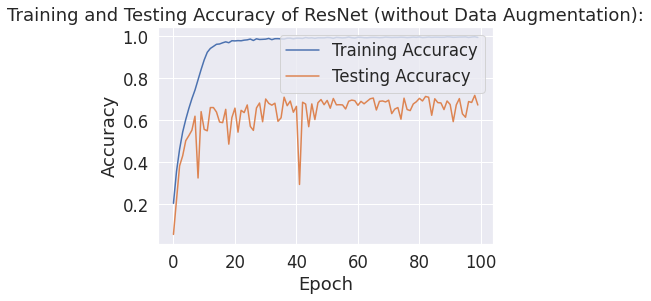

In [44]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Training and Testing Accuracy of ResNet (without Data Augmentation):')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper right')
plt.show()

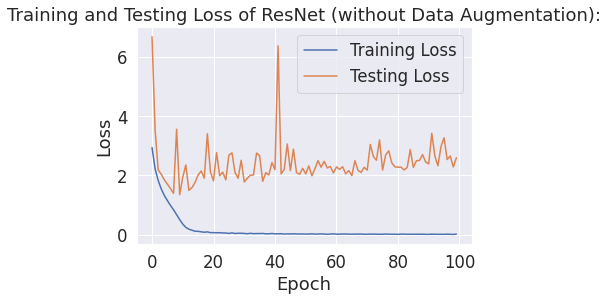

In [45]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Training and Testing Loss of ResNet (without Data Augmentation):')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.show()

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm.max() / 2.
                                                 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%.2f'%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

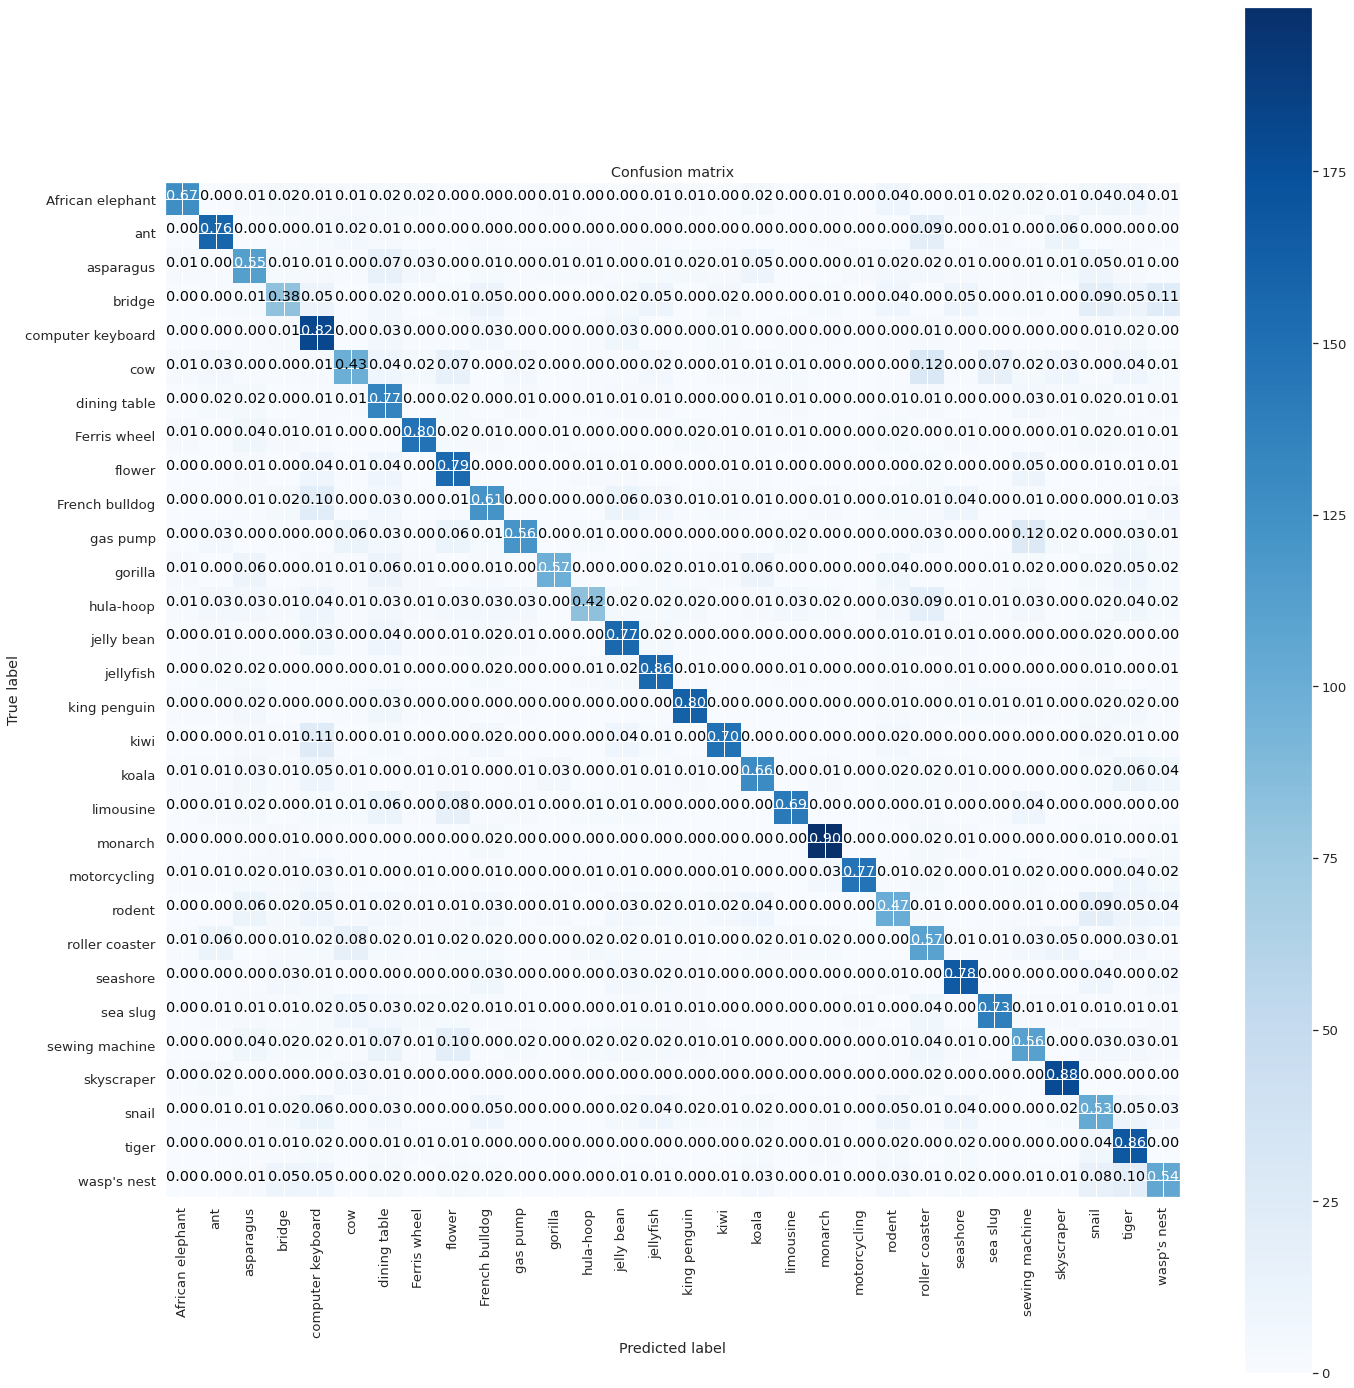

In [49]:
# Predict the values from the validation dataset
Y_pred = model4.predict(testing_images_norm)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
confusion_mtx = confusion_matrix(test_label, Y_pred_classes) 
# Plot the confusion matrix
plt.figure(figsize=(20,20))
sns.set(font_scale=1.0)
plot_confusion_matrix(confusion_mtx, classes = ["African elephant", "ant", "asparagus", "bridge", "computer keyboard","cow","dining table","Ferris wheel","flower","French bulldog","gas pump","gorilla","hula-hoop","jelly bean","jellyfish","king penguin","kiwi","koala","limousine","monarch","motorcycling","rodent","roller coaster","seashore","sea slug","sewing machine","skyscraper","snail","tiger","wasp's nest"])